## YOLO + SAM Prediction

Import Yolo and setup paths

In [ ]:
import napari
viewer = napari.Viewer()
import segment_everything
from segment_everything.object_detectors.yolo_detector import YoloDetector
from pathlib import Path
from segment_everything.weights_helper import get_weights_path
print(segment_everything.__version__)
print(segment_everything.__file__)

/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} 

0.1.0
/home/bnorthan/code/i2k/tnia/segment-everything/src/segment_everything/__init__.py


/home/bnorthan/code/i2k/tnia/segment-everything/src/segment_everything/vendored/efficientvit/models/nn/ops.py:407: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


### Load test image

<Image layer 'image' at 0x726111033010>

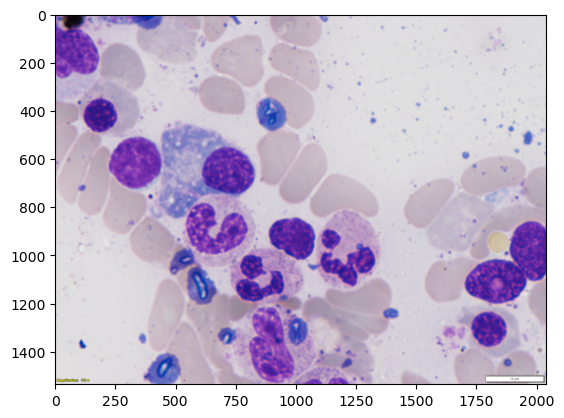

In [2]:
tnia_images_path = Path(r"D:\images")
tnia_images_path = Path(r"/home/bnorthan/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2025_05_10_SOTA_Test_Set')
from skimage.io import imread
import matplotlib.pyplot as plt


img = imread(parent_path / r"TestHidden_005.bmp")    
plt.imshow(img)
viewer.add_image(img, name="image")

Set up a default 8m YoloDetector 

In [3]:
yolo_detector_object_aware = YoloDetector(str(get_weights_path("ObjectAwareModel")), "ObjectAwareModelFromMobileSamV2", device='cuda')

/home/bnorthan/code/i2k/tnia/segment-everything/src/segment_everything/vendored/object_detection/ultralytics/yolo/utils/checks.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


Generate bounding boxes with YOLO

In [4]:
results = yolo_detector_object_aware.get_results(img, conf=0.3, imgsz=512)


0: 416x512 81 objects, 52.6ms
Speed: 5.4ms preprocess, 52.6ms inference, 115.8ms postprocess per image at shape (1, 3, 512, 512)


Get the classes and the bounding boxes from the Yolo result

In [5]:
classes = results[0].boxes.cls.cpu().numpy()
bbs=results[0].boxes.xyxy.cpu().numpy()

# add bbs to Napari
shapes_layer=viewer.add_shapes(shape_type='rectangle', face_color='transparent', edge_color='green', name='bboxes')

for box in bbs:
    bbox = [[box[1], box[0]], [box[3], box[2]]]
    shapes_layer.add(bbox)

Create a new stacked labels by segmenting the first stacked labels (with bounding boxes only) with MobileSAMV2

In [6]:
from segment_everything.stacked_labels import StackedLabels
from segment_everything.detect_and_segment import segment_from_bbox
from segment_everything.weights_helper import create_sam_model

In [9]:
model = create_sam_model("MobileSamV2")

mask_list = segment_from_bbox(img, bbs, model, "cuda")

stacked_labels = StackedLabels(mask_list)

VIT checkpoint loaded successfully


In [8]:

stacked_labels.make_3d_label_image()
viewer.add_labels(stacked_labels.label_image, name="3D Labels")

<Labels layer '3D Labels' at 0x79ca0413ac90>